# Olist Customer Segmentation
GitHub location: https://github.com/LarsTinnefeld/olist_ecom_analysis.git

This project is part of a larger Olist ecommerce business analysis and is the capstone project for the Udacity Data Science Nanodegree Program.

![logo](https://i2.wp.com/dataneophyte.com/wp-content/uploads/2019/12/Logo-01.png?resize=513%2C401&ssl=1)

## Questions to answer
1. What is the demographic relationship between customers?
2. Can we draw conclusions from RFM segmentation?
3. Can we develop a model to recommend how to target customer groups?
---
## Table of Contents

I. [Data Import and Wrangling](#data)<br>
II. [Exploratory Analysis](#eda)<br>
III. [Customer Segmentation](#segmentation)<br>
IV. [RFM Analysis](#rfm)<br>
V. [K Means Clustering](#k_means)<br>
VI. [Evaluation](#evaluation)<br>
VII. [Conclusion](#conclusion)

---
## <a class="anchor" id="data">I. Data Import and Wrangling</a>

### 1. Libraries

In [136]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import re
import seaborn as sns
from pywaffle import Waffle

import plotly as py
import plotly.offline as offline
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import Scatter, Figure, Layout
from plotly import tools

init_notebook_mode(connected=True)
%matplotlib inline

### 2. Importing data

Data structure:

<img src="https://i.imgur.com/HRhd2Y0.png" width="700" height="450">

**Customer data:**

In [137]:
# Customer lookup table
df_customer = pd.read_csv("../0 - data/olist_customers_dataset.csv")

In [138]:
# Taking a peek
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [139]:
df_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


This looks like a complete dataset. Doublecheck:

In [140]:
df_customer.isna().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [141]:
# Finding duplicates
df_customer.duplicated().sum()

0

**Order data:**

In [142]:
df_orders = pd.read_csv('../0 - data/df_orders_consolidated.csv')

In [143]:
df_orders.head()

,Unnamed: 0,Unnamed: 0.1,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,order_line_cube_in_ltr,price_round,customer_unique_id
0,0,0,2e7a8482f6fb09756ca50c10d7bfc047,08c5351a6aca1c1589a38f244edeee9d,shipped,2016-09-04,2016-10-07,2016-10-18,2016-11-09,2016-10-20,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,b7d76e111c89f7ebf14761390f0f7d17
1,1,1,35d3a51724a47ef1d0b89911e39cc4ff,27ab53f26192510ff85872aeb3759dcc,delivered,2016-10-04,2016-10-05,2016-10-14,2016-10-26,2016-12-20,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,f922896769e9517ea3c630f3c8de86d0
2,2,2,c4f710df20f7d1500da1aef81a993f65,4b671f05b6eb9dc1d2c1bae9c8c78536,delivered,2016-10-10,2016-10-10,2016-10-18,2016-10-26,2016-12-14,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,0ecf7f65b5ff3b9e61b637e59f495e0a
3,3,3,81e5043198a44ddeb226002ff55d8ad4,ddd15ef77c83eea8c534d2896173a927,delivered,2017-01-09,2017-01-09,2017-01-09,2017-02-24,2017-02-24,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,10.752,40.0,853ba75a0b423722ccf270eea3b4cfe4
4,4,4,03b218d39c422c250f389120c531b61f,db857a86c685a6a3a02a705961ec1ff1,delivered,2017-01-14,2017-01-14,2017-01-16,2017-01-18,2017-03-01,...,59.0,426.0,2.0,1400.0,32.0,6.0,28.0,5.376,40.0,c83d504c46170342ddbc93c762e0e4ec


In [144]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102425 entries, 0 to 102424
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Unnamed: 0                     102425 non-null  int64  
 1   Unnamed: 0.1                   102425 non-null  int64  
 2   order_id                       102425 non-null  object 
 3   customer_id                    102425 non-null  object 
 4   order_status                   102425 non-null  object 
 5   order_purchase_timestamp       102425 non-null  object 
 6   order_approved_at              102425 non-null  object 
 7   order_delivered_carrier_date   102425 non-null  object 
 8   order_delivered_customer_date  102425 non-null  object 
 9   order_estimated_delivery_date  102425 non-null  object 
 10  order_time                     102425 non-null  object 
 11  delivery_time                  102425 non-null  object 
 12  date_ordinal                  

This is a cleaned data table from previous analysis. All missing values are added, all duplicated entries are removed and order lines were consolidated. We only need to format the date fields into datetime format.

In [145]:
def convert_to_dt(dat, cols):
    '''Function takes in a dataframe name and date columns for conversion into datetime format'''
    for col in cols:
        dat[col] = pd.to_datetime(dat[col]).dt.date

# converting dates to datetime
convert_to_dt(df_orders, [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date'
    ])

In [146]:
df_orders.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

**Gepgraphic data:**

In [147]:
df_geolocation = pd.read_csv('../0 - data/olist_geolocation_dataset.csv')

In [148]:
df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [149]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [150]:
df_geolocation['geolocation_zip_code_prefix'].value_counts()

24220    1146
24230    1102
38400     965
35500     907
11680     879
         ... 
73990       1
87307       1
72450       1
24877       1
38198       1
Name: geolocation_zip_code_prefix, Length: 19015, dtype: int64

The zip code prefix' are not unique. That means we can not assign look up one distict coordinate for a customer but need to apply an aggregate function. I will use the mean for longitude and latitude. In that way a coordinate is in the middle of the neighbohood with this zip code. The downside is, that for visualizations, where will be multiple dots on the same spot, and the upper most is the one which is visible. I need to to solve this with an aggregate function again (mode e. g.).

---
## <a class="anchor" id="eda">II. Exploratory Data Analysis</a>
The focus is on getting an understanding around customers and the demographic relationship between them.

In [151]:
n_customers = df_customer['customer_unique_id'].nunique()
print('Unique customers: {}'.format(n_customers))
n_cities = df_customer['customer_city'].nunique()
print('Unique cities: {}'.format(n_cities))

Unique customers: 96096
Unique cities: 4119


Where are the customers from?

In [152]:
# City disctribution
df_customer['customer_city'].value_counts().sort_values(ascending=False)

sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
jurema                   1
populina                 1
conrado                  1
porto murtinho           1
sao jorge d'oeste        1
Name: customer_city, Length: 4119, dtype: int64

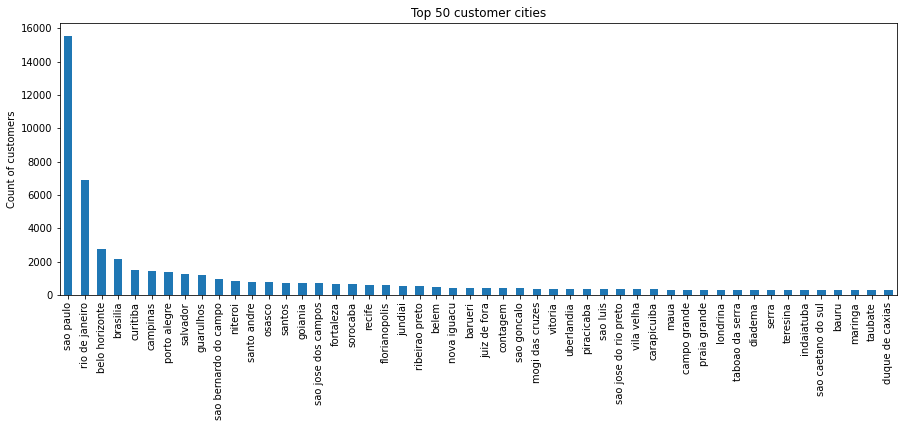

In [153]:
df_customer['customer_city']\
    .value_counts()\
    .sort_values(ascending=False)\
    .head(50)\
    .plot(kind='bar', figsize=(15, 5));

plt.title('Top 50 customer cities');
plt.ylabel('Count of customers');

In [154]:
# How many states are the customers from?
df_customer['customer_state'].nunique()

27

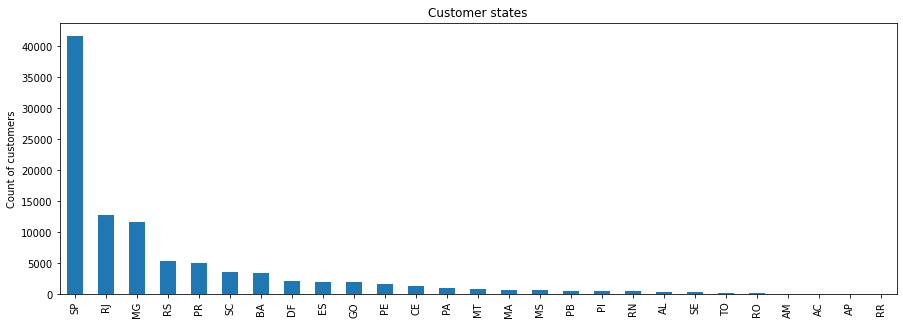

In [155]:
# States disctribution
df_customer['customer_state']\
    .value_counts()\
    .sort_values(ascending=False)\
    .plot(kind='bar', figsize=(15, 5));

plt.title('Customer states');
plt.ylabel('Count of customers');

In [156]:
# How many zip codes?
df_customer['customer_zip_code_prefix'].nunique()

14994

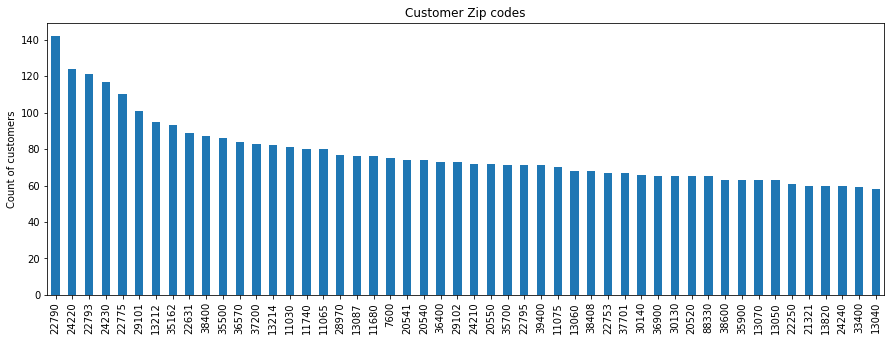

In [157]:
# Top 50 zip codes
df_customer['customer_zip_code_prefix']\
    .value_counts()\
    .sort_values(ascending=False)\
    .head(50)\
    .plot(kind='bar', figsize=(15, 5));

plt.title('Customer Zip codes');
plt.ylabel('Count of customers');

Let's review when new customers appeared.

In [158]:
df_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_time', 'delivery_time', 'date_ordinal', 'shipping_time_delta',
       'shipping_duration', 'estimated_duration', 'product_id', 'qty',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_line_cube_in_ltr', 'price_round', 'customer_unique_id'],
      dtype='object')

In [159]:
df_customer_dly = df_orders.groupby('customer_unique_id', as_index=False)\
    .agg({'order_purchase_timestamp': 'min'})

In [160]:
df_customer_dly.head()

,customer_unique_id,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07
2,0000f46a3911fa3c0805444483337064,2017-03-10
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14


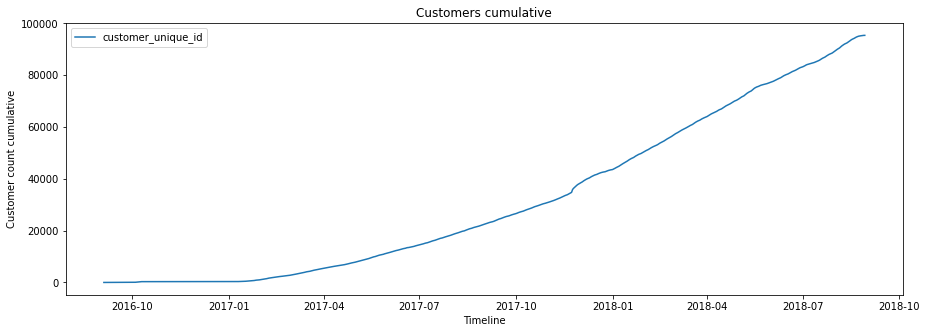

In [161]:
df_customer_dly.groupby('order_purchase_timestamp').count().cumsum().plot(figsize=(15,5))
plt.title('Customers cumulative')
plt.xlabel('Timeline')
plt.ylabel('Customer count cumulative');

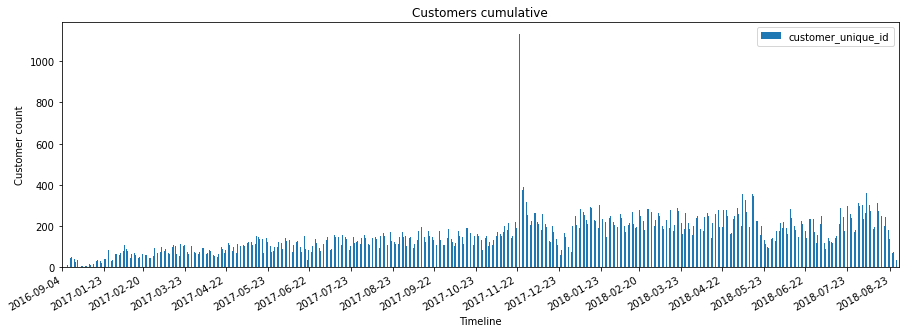

In [162]:
# New customers count by day
ax = df_customer_dly.groupby('order_purchase_timestamp').count().plot(kind='bar', figsize=(15,5))
# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
# set font and rotation for date tick labels
plt.gcf().autofmt_xdate()
plt.title('Customers cumulative')
plt.xlabel('Timeline')
plt.ylabel('Customer count');

## Conclusion

- There is a clear ranking for the customer location, which most likely has to do with population size distribution
- Many new cutomers appeared on Black Friday. It is interesting to see that the impact is not very pronounced when looking at the cumulative customer count.
- Overall, the increase of customers has an upward trend. The trendline is slightly exponential, which means that the growth is accelerating slowly.

---
## <a class="anchor" id="segmentation">III. Customer Segmentation</a>
The segmentation will classify customers based on their bying frequency, amount of purchases and money spent.

Question to answer:
- How are customers segmented according time of purchase, purchase amount and number of orders?

In [163]:
# Refresher
df_orders.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_time', 'delivery_time', 'date_ordinal', 'shipping_time_delta',
       'shipping_duration', 'estimated_duration', 'product_id', 'qty',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'order_line_cube_in_ltr', 'price_round', 'customer_unique_id'],
      dtype='object')

In [164]:
# Create a work copy
df = df_orders[[
    'customer_unique_id',
    'order_id',
    'order_status',
    'order_purchase_timestamp',
    'product_id',
    'qty',
    'price',
    'product_category_name'
    ]].copy()

We only are interested in customers which completed the interaction (`order_status` = "delivered")

In [165]:
df['order_status'].value_counts()

delivered      100196
shipped          1127
canceled          465
invoiced          322
processing        306
unavailable         7
approved            2
Name: order_status, dtype: int64

In [166]:
df = df[df['order_status']=='delivered']

In [167]:
df['order_status'].value_counts()

delivered    100196
Name: order_status, dtype: int64

We will pretend that the last day in the dataset represents the current day. Based on this, we calculate the number of days between the purchase and "Today"

In [168]:
# Setting reference day
df['today'] = df['order_purchase_timestamp'].max()
# Date deltas
df['delta_purchase_today'] = df['today'] - df['order_purchase_timestamp']

In [169]:
# Need to get the total price for an order line
df['total_price'] = df['qty'] * df['price']

In [170]:
df.head()

,customer_unique_id,order_id,order_status,order_purchase_timestamp,product_id,qty,price,product_category_name,today,delta_purchase_today,total_price
1,f922896769e9517ea3c630f3c8de86d0,35d3a51724a47ef1d0b89911e39cc4ff,delivered,2016-10-04,c1488892604e4ba5cff5b4eb4d595400,1,39.99,moveis_decoracao,2018-08-29,694 days,39.99
2,0ecf7f65b5ff3b9e61b637e59f495e0a,c4f710df20f7d1500da1aef81a993f65,delivered,2016-10-10,c1488892604e4ba5cff5b4eb4d595400,1,39.99,moveis_decoracao,2018-08-29,688 days,39.99
3,853ba75a0b423722ccf270eea3b4cfe4,81e5043198a44ddeb226002ff55d8ad4,delivered,2017-01-09,c1488892604e4ba5cff5b4eb4d595400,2,38.50,moveis_decoracao,2018-08-29,597 days,77.00
4,c83d504c46170342ddbc93c762e0e4ec,03b218d39c422c250f389120c531b61f,delivered,2017-01-14,c1488892604e4ba5cff5b4eb4d595400,1,38.50,moveis_decoracao,2018-08-29,592 days,38.50
5,6228bfcc46762217dfb30909688d80be,9b2e5e7107f9b0d28873782803e01ecd,delivered,2017-01-17,c1488892604e4ba5cff5b4eb4d595400,1,38.50,moveis_decoracao,2018-08-29,589 days,38.50


In [171]:
# Grouping by customer and order (same order_id = same day)
df_segmented_customers = df.groupby(['customer_unique_id', 'order_id'], as_index=False)\
    .agg({
        'order_purchase_timestamp': 'first',
        'qty': 'sum',
        'total_price': 'sum',
        'today': 'first',
        'delta_purchase_today': 'first'
        })

In [172]:
df_segmented_customers

,customer_unique_id,order_id,order_purchase_timestamp,qty,total_price,today,delta_purchase_today
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10,1,129.90,2018-08-29,111 days
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07,1,18.90,2018-08-29,114 days
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10,1,69.00,2018-08-29,537 days
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12,1,25.99,2018-08-29,321 days
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14,1,180.00,2018-08-29,288 days
...,...,...,...,...,...,...,...
96473,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08,2,1570.00,2018-08-29,447 days
96474,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10,1,64.89,2018-08-29,262 days
96475,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07,1,89.90,2018-08-29,568 days
96476,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02,1,115.00,2018-08-29,119 days


In [173]:
df_segmented_customers['delta_purchase_today']\
    = df_segmented_customers['delta_purchase_today'].astype(str)
df_segmented_customers['delta_purchase_today']\
    = df_segmented_customers['delta_purchase_today'].str.replace(r'\s+days.*', '', regex=True)
df_segmented_customers['delta_purchase_today']\
    = df_segmented_customers['delta_purchase_today'].astype(int)

In [174]:
df_segmented_customers

,customer_unique_id,order_id,order_purchase_timestamp,qty,total_price,today,delta_purchase_today
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10,1,129.90,2018-08-29,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07,1,18.90,2018-08-29,114
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10,1,69.00,2018-08-29,537
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12,1,25.99,2018-08-29,321
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14,1,180.00,2018-08-29,288
...,...,...,...,...,...,...,...
96473,fffcf5a5ff07b0908bd4e2dbc735a684,725cf8e9c24e679a8a5a32cb92c9ce1e,2017-06-08,2,1570.00,2018-08-29,447
96474,fffea47cd6d3cc0a88bd621562a9d061,c71b9252fd7b3b263aaa4cb09319a323,2017-12-10,1,64.89,2018-08-29,262
96475,ffff371b4d645b6ecea244b27531430a,fdc45e6c7555e6cb3cc0daca2557dbe1,2017-02-07,1,89.90,2018-08-29,568
96476,ffff5962728ec6157033ef9805bacc48,94d3ee0bc2a0af9d4fa47a4d63616e8d,2018-05-02,1,115.00,2018-08-29,119


In [175]:
df_segmented_customers = df_segmented_customers.groupby('customer_unique_id', as_index=False)\
    .agg({'delta_purchase_today': ['min', 'max', 'count'], 'total_price': ['sum', 'mean']})

In [177]:
# Check
df['customer_unique_id'].nunique()

93358

In [178]:
# Simplifying columns
df_segmented_customers.columns = [' '.join(col).strip() for col in df_segmented_customers.columns.values]

In [179]:
df_segmented_customers.head()

,customer_unique_id,delta_purchase_today min,delta_purchase_today max,delta_purchase_today count,total_price sum,total_price mean
0,0000366f3b9a7992bf8c76cfdf3221e2,111,111,1,129.90,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,114,1,18.90,18.90
2,0000f46a3911fa3c0805444483337064,537,537,1,69.00,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,321,1,25.99,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,288,1,180.00,180.00


In [180]:
# Renaming columns
df_segmented_customers.rename(columns={
    'delta_purchase_today min': 'days_since_first_order',
    'delta_purchase_today max': 'days_since_last_order',
    'delta_purchase_today count': 'orders_placed',
    'total_price sum': 'total_payment',
    'total_price mean': 'avg_payment'
    }, inplace=True)

In [181]:
# Defining time range conditions for classifying customers
total_time_range = str(df["order_purchase_timestamp"].max() - df["order_purchase_timestamp"].min())
total_time_range

'713 days, 0:00:00'

In [182]:
# Splitting total time range in 4 time periods
period = int(re.sub(r'\s+days.*', '', total_time_range))/4

## Assigning activity clasifications

In [183]:
# activity classes
class_inactive = df_segmented_customers['days_since_last_order'] > period * 3
class_cold = (df_segmented_customers['days_since_last_order'] > period * 2)\
    & (df_segmented_customers['days_since_last_order'] <= period * 3)
class_hot = (df_segmented_customers['days_since_last_order'] > period)\
    & (df_segmented_customers['days_since_last_order'] <= period * 2)
class_active = df_segmented_customers['days_since_last_order'] <= period

In [184]:
# Adding activity classes to dataframe
df_segmented_customers.loc[class_inactive, "segment"] = "inactive"
df_segmented_customers.loc[class_cold, "segment"] = "cold"
df_segmented_customers.loc[class_hot, "segment"] = "hot"
df_segmented_customers.loc[class_active, "segment"] = "active"

In [185]:
# Check
df_segmented_customers.head()

,customer_unique_id,days_since_first_order,days_since_last_order,orders_placed,total_payment,avg_payment,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,111,111,1,129.90,129.90,active
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,114,1,18.90,18.90,active
2,0000f46a3911fa3c0805444483337064,537,537,1,69.00,69.00,inactive
3,0000f6ccb0745a6a4b88665a16c9f078,321,321,1,25.99,25.99,hot
4,0004aac84e0df4da2b147fca70cf8255,288,288,1,180.00,180.00,hot


In [186]:
# Defining payment range conditions for classifying customers
median_payment = df_segmented_customers['avg_payment'].median()

In [187]:
# Sub classes
class_inactive_low = df_segmented_customers['segment'] == 'inactive'
class_cold_low = (df_segmented_customers['segment'] == 'cold')\
    & (df_segmented_customers['avg_payment'] < median_payment)
class_cold_high = (df_segmented_customers['segment'] == 'cold')\
    & (df_segmented_customers['avg_payment'] >= median_payment)
class_hot_low = (df_segmented_customers['segment'] == 'hot')\
    & (df_segmented_customers['avg_payment'] < median_payment)
class_hot_high = (df_segmented_customers['segment'] == 'hot')\
    & (df_segmented_customers['avg_payment'] >= median_payment)
class_active_low = (df_segmented_customers['segment'] == 'active')\
    & (df_segmented_customers['avg_payment'] < median_payment)
class_active_high = (df_segmented_customers['segment'] == 'active')\
    & (df_segmented_customers['avg_payment'] >= median_payment)

In [188]:
# Adding sub classes to dataframe
df_segmented_customers.loc[class_inactive_low, "sub_segment"] = "inactive"
df_segmented_customers.loc[class_cold_low, "sub_segment"] = "cold_low"
df_segmented_customers.loc[class_cold_high, "sub_segment"] = "cold_high"
df_segmented_customers.loc[class_hot_low, "sub_segment"] = "hot_low"
df_segmented_customers.loc[class_hot_high, "sub_segment"] = "hot_high"
df_segmented_customers.loc[class_active_low, "sub_segment"] = "active_low"
df_segmented_customers.loc[class_active_high, "sub_segment"] = "active_high"

In [189]:
df_segmented_customers['active_days']\
    = df_segmented_customers['days_since_first_order']\
    - df_segmented_customers['days_since_last_order'] + 1

In [190]:
df_segmented_customers.head()

,customer_unique_id,days_since_first_order,days_since_last_order,orders_placed,total_payment,avg_payment,segment,sub_segment,active_days
0,0000366f3b9a7992bf8c76cfdf3221e2,111,111,1,129.90,129.90,active,active_high,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,114,1,18.90,18.90,active,active_low,1
2,0000f46a3911fa3c0805444483337064,537,537,1,69.00,69.00,inactive,inactive,1
3,0000f6ccb0745a6a4b88665a16c9f078,321,321,1,25.99,25.99,hot,hot_low,1
4,0004aac84e0df4da2b147fca70cf8255,288,288,1,180.00,180.00,hot,hot_high,1


In [191]:
df_segmented_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_unique_id      93358 non-null  object 
 1   days_since_first_order  93358 non-null  int32  
 2   days_since_last_order   93358 non-null  int32  
 3   orders_placed           93358 non-null  int64  
 4   total_payment           93358 non-null  float64
 5   avg_payment             93358 non-null  float64
 6   segment                 93358 non-null  object 
 7   sub_segment             93358 non-null  object 
 8   active_days             93358 non-null  int32  
dtypes: float64(2), int32(3), int64(1), object(3)
memory usage: 6.1+ MB


In [192]:
dict_colors = {'inactive': 'midnightblue', 'cold_low': 'blue', 'cold_high': 'mediumslateblue', 'hot_low': 'darkorchid', 'hot_high': 'magenta', 'active_low': 'deeppink', 'active_high': 'red'}

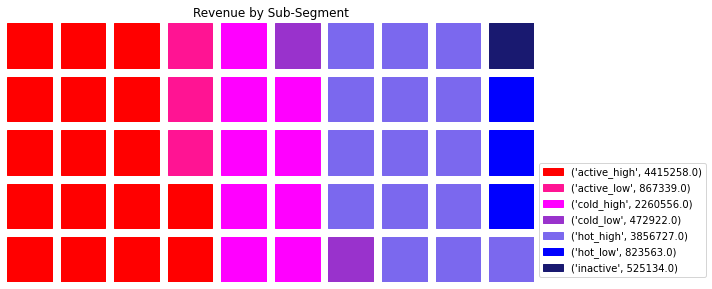

In [193]:
data_revenue = dict(round(df_segmented_customers\
    .groupby('sub_segment')\
    .agg({'total_payment': 'sum'}))['total_payment'])

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=data_revenue,
    labels=[f"{k, v}" for k, v in data_revenue.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
    colors=('red', 'deeppink', 'magenta', 'darkorchid', 'mediumslateblue', 'blue', 'midnightblue'),
    figsize=(10, 8)
)

plt.title('Revenue by Sub-Segment');

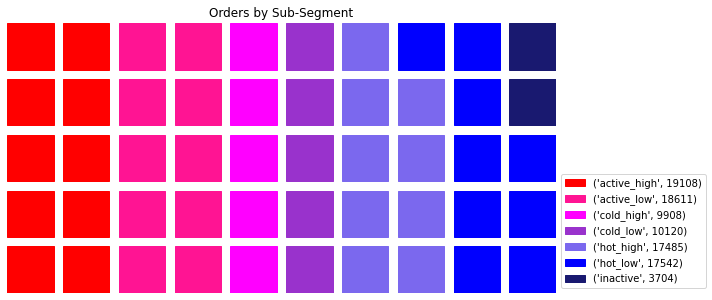

In [194]:
data_order = dict(round(df_segmented_customers\
    .groupby('sub_segment')\
    .agg({'orders_placed': 'sum'}))['orders_placed'])

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=data_order,
    labels=[f"{k, v}" for k, v in data_order.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
    colors=('red', 'deeppink', 'magenta', 'darkorchid', 'mediumslateblue', 'blue', 'midnightblue'),
    figsize=(10, 8)
)

plt.title('Orders by Sub-Segment');

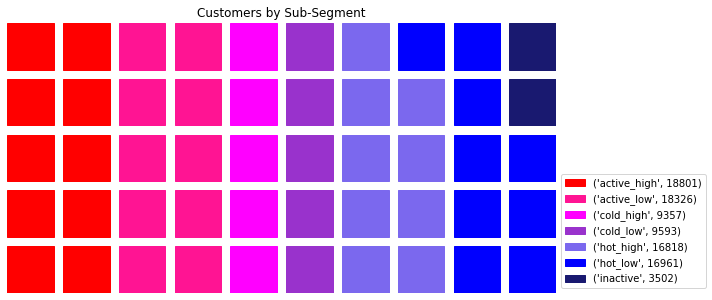

In [195]:
data_customers = dict(round(df_segmented_customers\
    .groupby('sub_segment')\
    .agg({'customer_unique_id': 'count'}))['customer_unique_id'])

fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=data_customers,
    labels=[f"{k, v}" for k, v in data_customers.items()],
    legend={'loc': 'lower left', 'bbox_to_anchor': (1, 0)},
    colors=('red', 'deeppink', 'magenta', 'darkorchid', 'mediumslateblue', 'blue', 'midnightblue'),
    figsize=(10, 8)
)

plt.title('Customers by Sub-Segment');

### Geo-demographic clusters

In the next step relationship between the purchase behavior and geographic location will be visualized.

In [196]:
df_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [197]:
df_geolocation.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [198]:
# Making dictionary as preparation for mapping zip code
dict_cust_zip = df_customer.set_index('customer_unique_id').to_dict()['customer_zip_code_prefix']

In [199]:
# Adding zip code to df
df_segmented_customers['geolocation_zip_code_prefix']\
    = df_segmented_customers['customer_unique_id'].map(dict_cust_zip)

In [200]:
df_segmented_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_unique_id           93358 non-null  object 
 1   days_since_first_order       93358 non-null  int32  
 2   days_since_last_order        93358 non-null  int32  
 3   orders_placed                93358 non-null  int64  
 4   total_payment                93358 non-null  float64
 5   avg_payment                  93358 non-null  float64
 6   segment                      93358 non-null  object 
 7   sub_segment                  93358 non-null  object 
 8   active_days                  93358 non-null  int32  
 9   geolocation_zip_code_prefix  93358 non-null  int64  
dtypes: float64(2), int32(3), int64(2), object(3)
memory usage: 9.3+ MB


In [202]:
dict_lat = df_geolocation.set_index('geolocation_zip_code_prefix').to_dict()['geolocation_lat']
dict_lng = df_geolocation.set_index('geolocation_zip_code_prefix').to_dict()['geolocation_lng']

In [211]:
# Adding coordinates and color code
df_segmented_customers['geolocation_lat']\
    = df_segmented_customers['geolocation_zip_code_prefix'].map(dict_lat)
df_segmented_customers['geolocation_lng']\
    = df_segmented_customers['geolocation_zip_code_prefix'].map(dict_lng)
df_segmented_customers['color']\
    = df_segmented_customers['sub_segment'].map(dict_colors)

In [218]:
df_segmented_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_unique_id           93358 non-null  object 
 1   days_since_first_order       93358 non-null  int32  
 2   days_since_last_order        93358 non-null  int32  
 3   orders_placed                93358 non-null  int64  
 4   total_payment                93358 non-null  float64
 5   avg_payment                  93358 non-null  float64
 6   segment                      93358 non-null  object 
 7   sub_segment                  93358 non-null  object 
 8   active_days                  93358 non-null  int32  
 9   geolocation_zip_code_prefix  93358 non-null  int64  
 10  geolocation_lat              93103 non-null  float64
 11  geolocation_lng              93103 non-null  float64
 12  color                        93358 non-null  object 
dtypes: float64(4), i

## Geo-demographic map of sub-segments

In [392]:
def plot_segment_map(df, title, dot_color):

    data_geo = [go.Scattermapbox(
        lon = df['geolocation_lng'],
        lat = df['geolocation_lat'],
        marker = dict(
            size = 4,
            color = dot_color
            )
        )]
    
    layout = dict(
            title = title,
            mapbox = dict(
                accesstoken = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA',
                center= dict(lat=-23.5,lon=-46.6),
                bearing=10,
                pitch=0,
                zoom=2
            )
        )
    fig = dict( data=data_geo, layout=layout )
    iplot( fig, validate=False)

In [380]:
# Because the coordinates of the customers are not unique (explanation in the data import) I need to extract the most common cutomer call (color)
sample_subsegments = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'geolocation_lat': 'first',
        'geolocation_lng': 'first',
        'color': lambda x:x.value_counts().index[0]
        }).sample(n=200)

In [381]:
plot_segment_map(sample_subsegments, 'Geological distribution of customer sub-segments', sample_subsegments.color)

As expected, the customers are concentrated around the big cities in the east of the country. On the first view, there is not a clear concentration of sub-segments in specific areas. 

## Areas with the most revenue

In [395]:
def plot_dot_map(df, title, upper_bound, metric):

    data_geo = [go.Scattermapbox(
        lon = df['geolocation_lng'],
        lat = df['geolocation_lat'],
        marker = dict(
            size = 4,
            color = df[metric],
            colorscale = 'Bluered',
            reversescale=True,
            cmin = df[metric].min(),
            cmax=upper_bound
            )
        )]
    
    layout = dict(
            title = title,
            mapbox = dict(
                accesstoken = 'pk.eyJ1IjoiaG9vbmtlbmc5MyIsImEiOiJjam43cGhpNng2ZmpxM3JxY3Z4ODl2NWo3In0.SGRvJlToMtgRxw9ZWzPFrA',
                center= dict(lat=-23.5,lon=-46.6),
                bearing=10,
                pitch=0,
                zoom=8,
            )
        )
    fig = dict( data=data_geo, layout=layout )
    iplot( fig, validate=False)

In [382]:
sample_renenue = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'total_payment': 'sum',
        'geolocation_lat': 'first',
        'geolocation_lng': 'first'
        }).sample(n=200)

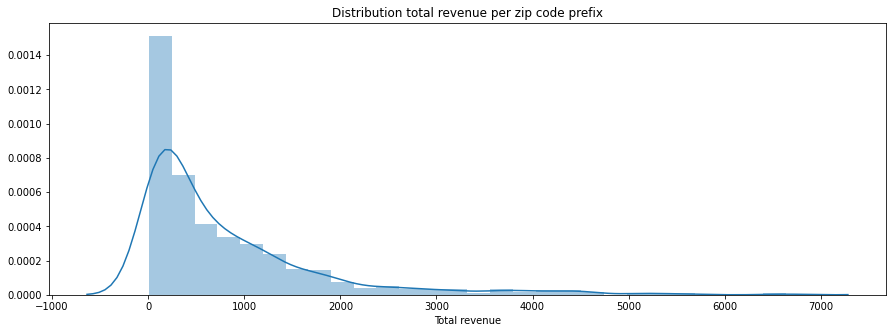

In [311]:
plt.figure(figsize=(15, 5))
sns.distplot(sample_renenue['total_payment']);
plt.title('Distribution total revenue per zip code prefix')
plt.xlabel('Total revenue');

In [383]:
plot_dot_map(sample_renenue, 'Zip codes with most revenue', 2000, 'total_payment')

The chart shows that there is some clustering between higher revenue and lower revenue areas. We need to keep in mind that the values here is a result of the product cost AND the number of purchased done in that neighborhood. That means a small number of expensive products can have the same value as a big number of cheap products.

## Distribution of average purchase value

In [399]:
sample_avg_spend = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'total_payment': 'mean',
        'geolocation_lat': 'first',
        'geolocation_lng': 'first'
        }).sample(n=100)

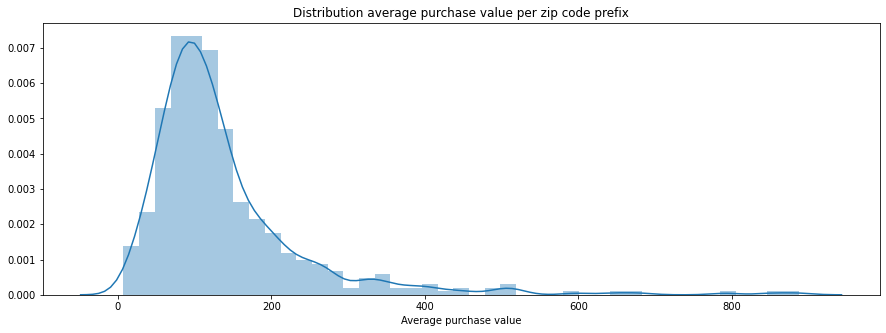

In [320]:
plt.figure(figsize=(15, 5))
sns.distplot(sample_avg_spend['total_payment']);
plt.title('Distribution average purchase value per zip code prefix')
plt.xlabel('Average purchase value');

In [400]:
plot_dot_map(sample_avg_spend, 'Average prchase value', 220, 'total_payment')

## Customer recency areas

In [386]:
sample_avg_newbies = df_segmented_customers.groupby(
    'geolocation_zip_code_prefix',
    as_index=False
    ).agg({
        'days_since_last_order': 'mean',
        'geolocation_lat': 'first',
        'geolocation_lng': 'first'
        }).sample(n=200)

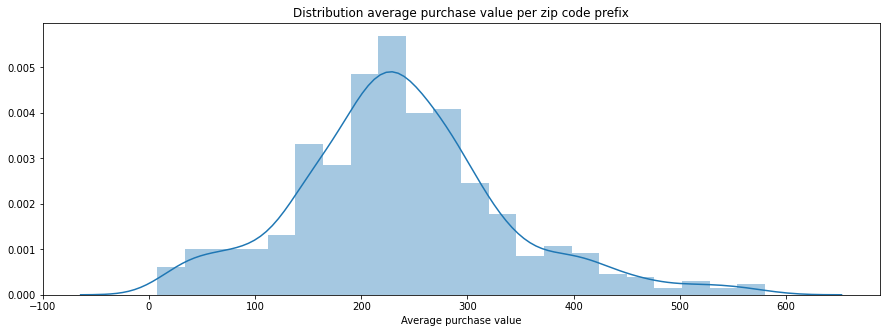

In [348]:
plt.figure(figsize=(15, 5))
sns.distplot(sample_avg_newbies['days_since_last_order']);
plt.title('Distribution average purchase value per zip code prefix')
plt.xlabel('Average purchase value');

In [387]:
plot_dot_map(sample_avg_newbies, 'Average prchase value', 400, 'days_since_last_order')

## Conclusion

- 7 customer sub-classes were defined and extracted from the dataset
- The strongest class is active customers with high spending, followed by "hot" customers which high spending, which is a good prospect for the business.
- Second stongest class in terms of members and orders placed are active customers with low spending.
- With the current data set and the applied method, there is not a clearly visible local clustering

This segmentation provides a base to develop a strategy how and if to target customers.

---
## <a class="anchor" id="rfm">IV. RFM Analysis</a>
...